# **CARGA DE DATOS Y LIBRERÍAS**

In [1]:
from google.colab import files

# Despliega el cuadro de diálogo para subir archivos
uploaded = files.upload()

# Listar los archivos subidos (opcional)
for file_name in uploaded.keys():
    print(f'Archivo subido: {file_name}')

Saving kaggle.json to kaggle.json
Archivo subido: kaggle.json


In [2]:
# Crea la carpeta .kaggle y mueve el archivo kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Cambia los permisos para el archivo kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Instala la Kaggle CLI
!pip install -q kaggle

# Descarga el dataset utilizando el identificador del nuevo dataset
!kaggle datasets download -d shreyag1103/brain-mri-scans-for-brain-tumor-classification

# Descomprimir el archivo descargado
!unzip -q brain-mri-scans-for-brain-tumor-classification.zip -d /content/brain_tumor_dataset

Dataset URL: https://www.kaggle.com/datasets/shreyag1103/brain-mri-scans-for-brain-tumor-classification
License(s): unknown
 90% 22.0M/24.4M [00:02<00:00, 11.8MB/s]
100% 24.4M/24.4M [00:02<00:00, 10.3MB/s]


In [4]:
import os
import shutil
import random
import numpy as np
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.models import resnet18, ResNet18_Weights
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from PIL import Image
import math
import pandas as pd
import itertools

# **CLASIFICACIÓN Y PREDICCIÓN CON PYTORCH**

In [5]:
# Directorio original de las imágenes
original_data_dir = '/content/brain_tumor_dataset/data'

# Nombres de las carpetas con las imágenes
folders = os.listdir(original_data_dir)

# Proporción de imágenes para el conjunto de validación
val_split = 0.2

# Crear el directorio para los datos divididos
split_data_dir = '/content/split_data'
os.makedirs(split_data_dir, exist_ok=True)

# Iterar sobre las carpetas y dividir las imágenes
for folder in folders:
    folder_path = os.path.join(original_data_dir, folder)
    images = os.listdir(folder_path)

    # Dividir las imágenes en train y val
    random.shuffle(images)
    split_index = int(len(images) * (1 - val_split))
    train_images = images[:split_index]
    val_images = images[split_index:]

    # Crear directorios para train y val en el directorio dividido
    train_dir = os.path.join(split_data_dir, 'train', folder)
    val_dir = os.path.join(split_data_dir, 'val', folder)
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Copiar las imágenes a los directorios correspondientes
    for image in train_images:
        src = os.path.join(folder_path, image)
        dst = os.path.join(train_dir, image)
        shutil.copy(src, dst)

    for image in val_images:
        src = os.path.join(folder_path, image)
        dst = os.path.join(val_dir, image)
        shutil.copy(src, dst)

print("División completa.")



División completa.


In [6]:
# Directorio de datos divididos
split_data_dir = '/content/split_data'

# Contadores para train y val
train_count = 0
val_count = 0

# Iterar sobre las carpetas de train y val y contar imágenes
for folder in ['train', 'val']:
    for subfolder in os.listdir(os.path.join(split_data_dir, folder)):
        folder_path = os.path.join(split_data_dir, folder, subfolder)
        num_images = len(os.listdir(folder_path))
        if folder == 'train':
            train_count += num_images
        elif folder == 'val':
            val_count += num_images

print(f"El número total de imágenes en train es: {train_count}")
print(f"El número total de imágenes en val es: {val_count}")


El número total de imágenes en train es: 1048
El número total de imágenes en val es: 263


In [11]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = split_data_dir
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
# Configuración del dispositivo (GPU o CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
# Carga el modelo con pesos preentrenados específicos
weights = ResNet18_Weights.DEFAULT  # Utiliza los pesos más actualizados disponibles
model = resnet18(weights=weights)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)  # Asumiendo que hay 4 categorías

if torch.cuda.is_available():
    model = model.cuda()



In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [14]:
def train_model(model, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

    return model

# Comenzar el entrenamiento
model = train_model(model, criterion, optimizer, num_epochs=25)


Epoch 0/24
----------
train Loss: 0.9120 Acc: 0.6441
val Loss: 0.4185 Acc: 0.8517

Epoch 1/24
----------
train Loss: 0.5945 Acc: 0.7977
val Loss: 0.3194 Acc: 0.9049

Epoch 2/24
----------
train Loss: 0.3915 Acc: 0.8693
val Loss: 0.3038 Acc: 0.9202

Epoch 3/24
----------
train Loss: 0.2464 Acc: 0.9084
val Loss: 0.2735 Acc: 0.9163

Epoch 4/24
----------
train Loss: 0.2232 Acc: 0.9380
val Loss: 0.2035 Acc: 0.9430

Epoch 5/24
----------
train Loss: 0.1991 Acc: 0.9313
val Loss: 0.2280 Acc: 0.9278

Epoch 6/24
----------
train Loss: 0.2090 Acc: 0.9361
val Loss: 0.1702 Acc: 0.9582

Epoch 7/24
----------
train Loss: 0.1831 Acc: 0.9361
val Loss: 0.1833 Acc: 0.9392

Epoch 8/24
----------
train Loss: 0.1615 Acc: 0.9580
val Loss: 0.2574 Acc: 0.9278

Epoch 9/24
----------
train Loss: 0.1396 Acc: 0.9580
val Loss: 0.2795 Acc: 0.9163

Epoch 10/24
----------
train Loss: 0.1289 Acc: 0.9628
val Loss: 0.2392 Acc: 0.9125

Epoch 11/24
----------
train Loss: 0.0957 Acc: 0.9771
val Loss: 0.2461 Acc: 0.9316

Ep

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Esta función imprime y traza el mapa de confusión.
    La normalización se puede aplicar configurando `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión Normalizada")
    else:
        print('Matriz de Confusión Sin Normalizar')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta Actual')
    plt.xlabel('Etiqueta Predicha')


In [16]:
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds


labels, preds = evaluate_model(model, dataloaders['val'])


Matriz de Confusión Sin Normalizar
[[54  5  1  0]
 [ 0 62  0  0]
 [ 0 10 71  0]
 [ 0  1  0 59]]


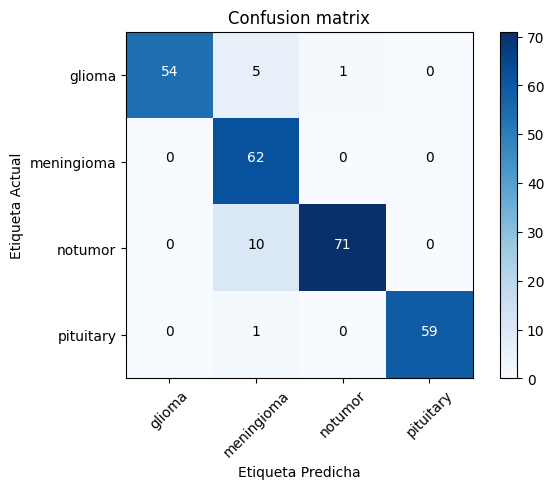

In [17]:
cm = confusion_matrix(labels, preds)
plot_confusion_matrix(cm, class_names)
plt.show()

In [18]:
labels, preds = evaluate_model(model, dataloaders['val'])

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [19]:
import pandas as pd
# Crear DataFrame
results_df = pd.DataFrame({'Etiqueta Actual': labels, 'Etiqueta Predicha': preds})

# Reemplazar los enteros por nombres de las clases si es necesario
class_names_mapping = {index: name for index, name in enumerate(class_names)}
results_df.replace({'Etiqueta Actual': class_names_mapping, 'Etiqueta Predicha': class_names_mapping}, inplace=True)

# Mostrar las primeras filas de la tabla para verificar
results_df.head(20)


,Etiqueta Actual,Etiqueta Predicha
0,pituitary,pituitary
1,pituitary,pituitary
2,notumor,notumor
3,glioma,meningioma
4,meningioma,meningioma
5,notumor,meningioma
6,notumor,notumor
7,pituitary,pituitary
8,meningioma,meningioma
9,notumor,notumor


In [20]:
def predict_image(image_path, model, class_names, transform):
    image = Image.open(image_path)
    image = image.convert('RGB')  # Convertir a RGB si es necesario
    image = transform(image).unsqueeze(0)  # Añadir una dimensión de batch

    model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            image = image.cuda()
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        probabilities = torch.nn.functional.softmax(outputs, dim=1) * 100
        predicted_label = class_names[preds[0]]
        probability = probabilities[0, preds[0]].item()

    print(f'Etiqueta Predicha: {predicted_label}')
    print(f'Probability: {probability:.2f}%')

    # Mostrar la imagen
    plt.imshow(Image.open(image_path))
    plt.title(f'{predicted_label} ({probability:.2f}%)')
    plt.show()

# Transformaciones necesarias
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


Etiqueta Predicha: glioma
Probability: 99.93%


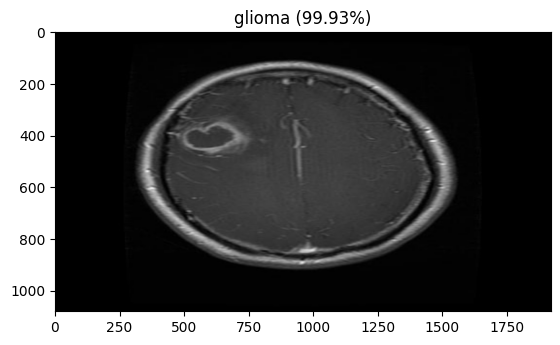

In [21]:
image_path = '/content/PRUEBA GL.png'
predict_image(image_path, model, class_names, transform)


Etiqueta Predicha: meningioma
Probability: 100.00%


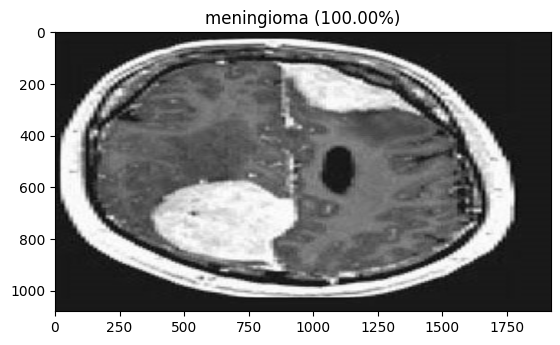

In [22]:
image_path = '/content/PRUEBA MEN.png'
predict_image(image_path, model, class_names, transform)

Etiqueta Predicha: pituitary
Probability: 99.91%


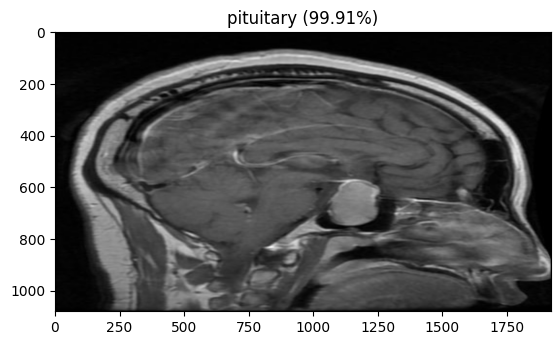

In [23]:
image_path = '/content/PRUEBA PI.png'
predict_image(image_path, model, class_names, transform)

Etiqueta Predicha: notumor
Probability: 100.00%


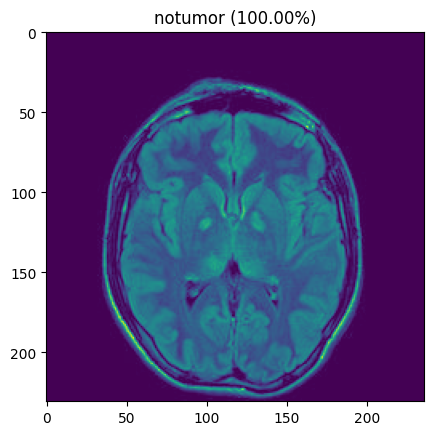

In [24]:
image_path = '/content/PRUEBA NO CANCER.png'
predict_image(image_path, model, class_names, transform)

## **Investigar Casos de Error**

In [25]:
# Obtener los índices de los casos donde las predicciones fueron incorrectas
incorrect_indices = [i for i, (pred, actual) in enumerate(zip(preds, labels)) if pred != actual]
print(f"Número de predicciones incorrectas: {len(incorrect_indices)}")


Número de predicciones incorrectas: 17


 LAS QUE NO COINCIDA EL NOMBRE EN AMBAS COLUMNAS SE IMPRIMA SU FOTO CORRESPONDIENTE JUNTO EN EL TITULO SU ETIQUETA PRECHA Y ACTUAL

In [26]:
# Filtrar el DataFrame para obtener solo las filas donde las etiquetas no coinciden
mismatches = results_df[results_df['Etiqueta Actual'] != results_df['Etiqueta Predicha']]
mismatches

,Etiqueta Actual,Etiqueta Predicha
3,glioma,meningioma
5,notumor,meningioma
21,notumor,meningioma
28,glioma,notumor
50,notumor,meningioma
59,notumor,meningioma
69,notumor,meningioma
110,glioma,meningioma
121,glioma,meningioma
133,notumor,meningioma


In [27]:
# Reconstruir rutas de imágenes desde el conjunto de datos
image_paths = [image_datasets['val'].imgs[idx][0] for idx in range(len(image_datasets['val']))]


In [28]:
# Obtener rutas de imágenes que corresponden a las filas de discrepancias en el DataFrame
mismatched_image_paths = [image_paths[idx] for idx in mismatches.index]


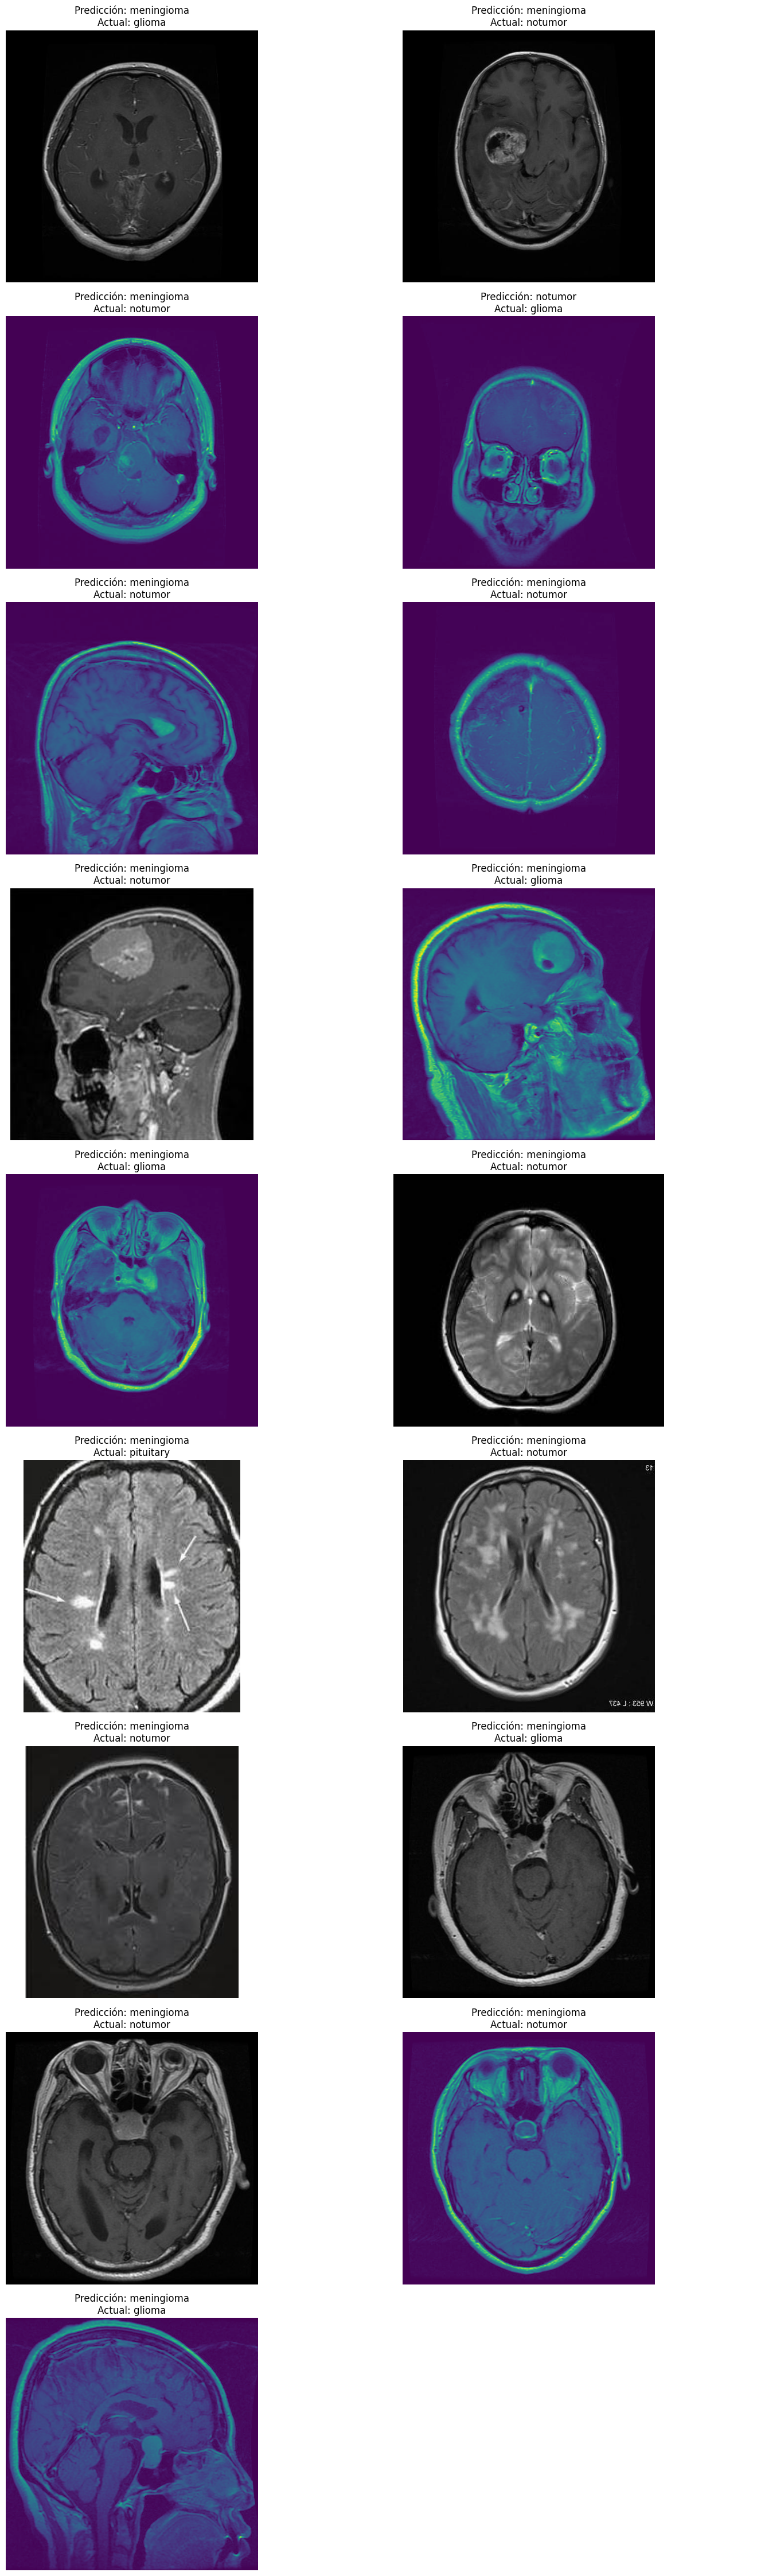

In [29]:
def show_mismatched_images(mismatches, mismatched_image_paths):
    num_images = len(mismatches)
    num_cols = 2
    num_rows = math.ceil(num_images / num_cols)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), squeeze=False)

    for ax, (idx, row), img_path in zip(axs.flatten(), mismatches.iterrows(), mismatched_image_paths):
        img = Image.open(img_path)
        ax.imshow(img)
        title = f"Predicción: {row['Etiqueta Predicha']}\nActual: {row['Etiqueta Actual']}"
        ax.set_title(title)
        ax.axis('off')

    # Eliminar ejes adicionales si el número de imágenes no es un múltiplo de num_cols
    for ax in axs.flatten()[num_images:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Llamada a la función con los datos correctos
show_mismatched_images(mismatches, mismatched_image_paths)


